# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

Ниже запись в файл hw2code для реализации некоторых заданий из пула

In [1]:
%%writefile hw2code.py
import numpy as np
from collections import Counter

def find_best_split(feature_vector, target_vector):
    """
    Находит оптимальный порог для разбиения вектора признака по критерию Джини.
    """
    sorted_indices = np.argsort(feature_vector)
    feature_vector = feature_vector[sorted_indices]
    target_vector = target_vector[sorted_indices]

    unique_indices = np.where(feature_vector[:-1] != feature_vector[1:])[0] + 1

    if len(unique_indices) == 0:
        return [], [], None, None

    thresholds = (feature_vector[unique_indices - 1] + feature_vector[unique_indices]) / 2.0

    N = len(target_vector)
    N_l = unique_indices
    N_r = N - N_l

    target_cumsum = np.cumsum(target_vector)
    v1_l = target_cumsum[unique_indices - 1]
    v0_l = N_l - v1_l

    v1_r = target_cumsum[-1] - v1_l
    v0_r = N_r - v1_r

    def calc_h(v1, v0, n):
        p1 = v1 / n
        p0 = v0 / n
        return 1 - p1**2 - p0**2

    H_l = calc_h(v1_l, v0_l, N_l)
    H_r = calc_h(v1_r, v0_r, N_r)

    ginis = - (N_l / N) * H_l - (N_r / N) * H_r

    max_ind = np.argmax(ginis)
    gini_best = ginis[max_ind]
    threshold_best = thresholds[max_ind]

    return thresholds, ginis, threshold_best, gini_best


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node, depth=0):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count

                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))
                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if len(np.unique(feature_vector)) < 2:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)

            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if self._min_samples_leaf is not None:
             if np.sum(split) < self._min_samples_leaf or np.sum(np.logical_not(split)) < self._min_samples_leaf:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        feature_type = self._feature_types[feature]

        if feature_type == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] in node["categories_split"]:
                 return self._predict_node(x, node["left_child"])
            else:
                 return self._predict_node(x, node["right_child"])

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

Writing hw2code.py


# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [11]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [12]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

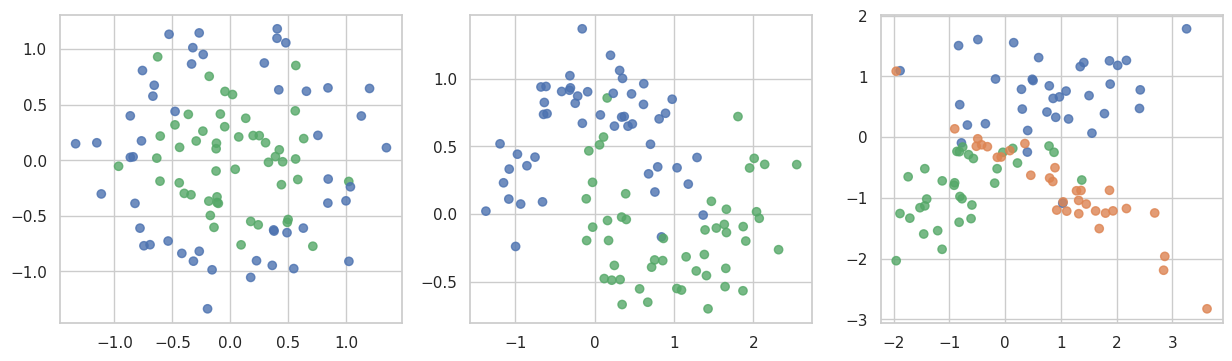

In [13]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [14]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [ ]:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1: Train Acc=1.000, Test Acc=0.650
Dataset 2: Train Acc=1.000, Test Acc=0.950
Dataset 3: Train Acc=1.000, Test Acc=0.700


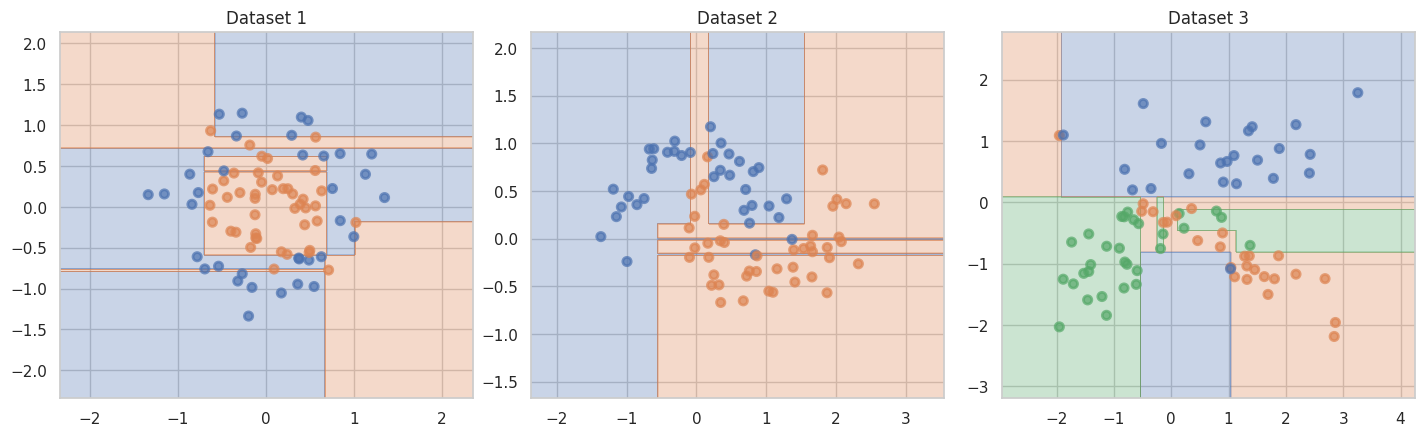

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 5))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    plt.subplot(1, 3, i + 1)
    plot_surface(clf, X_train, y_train)
    plt.title(f"Dataset {i+1}")

    #metrics
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"Dataset {i+1}: Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

plt.show()

__Ответ:__

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

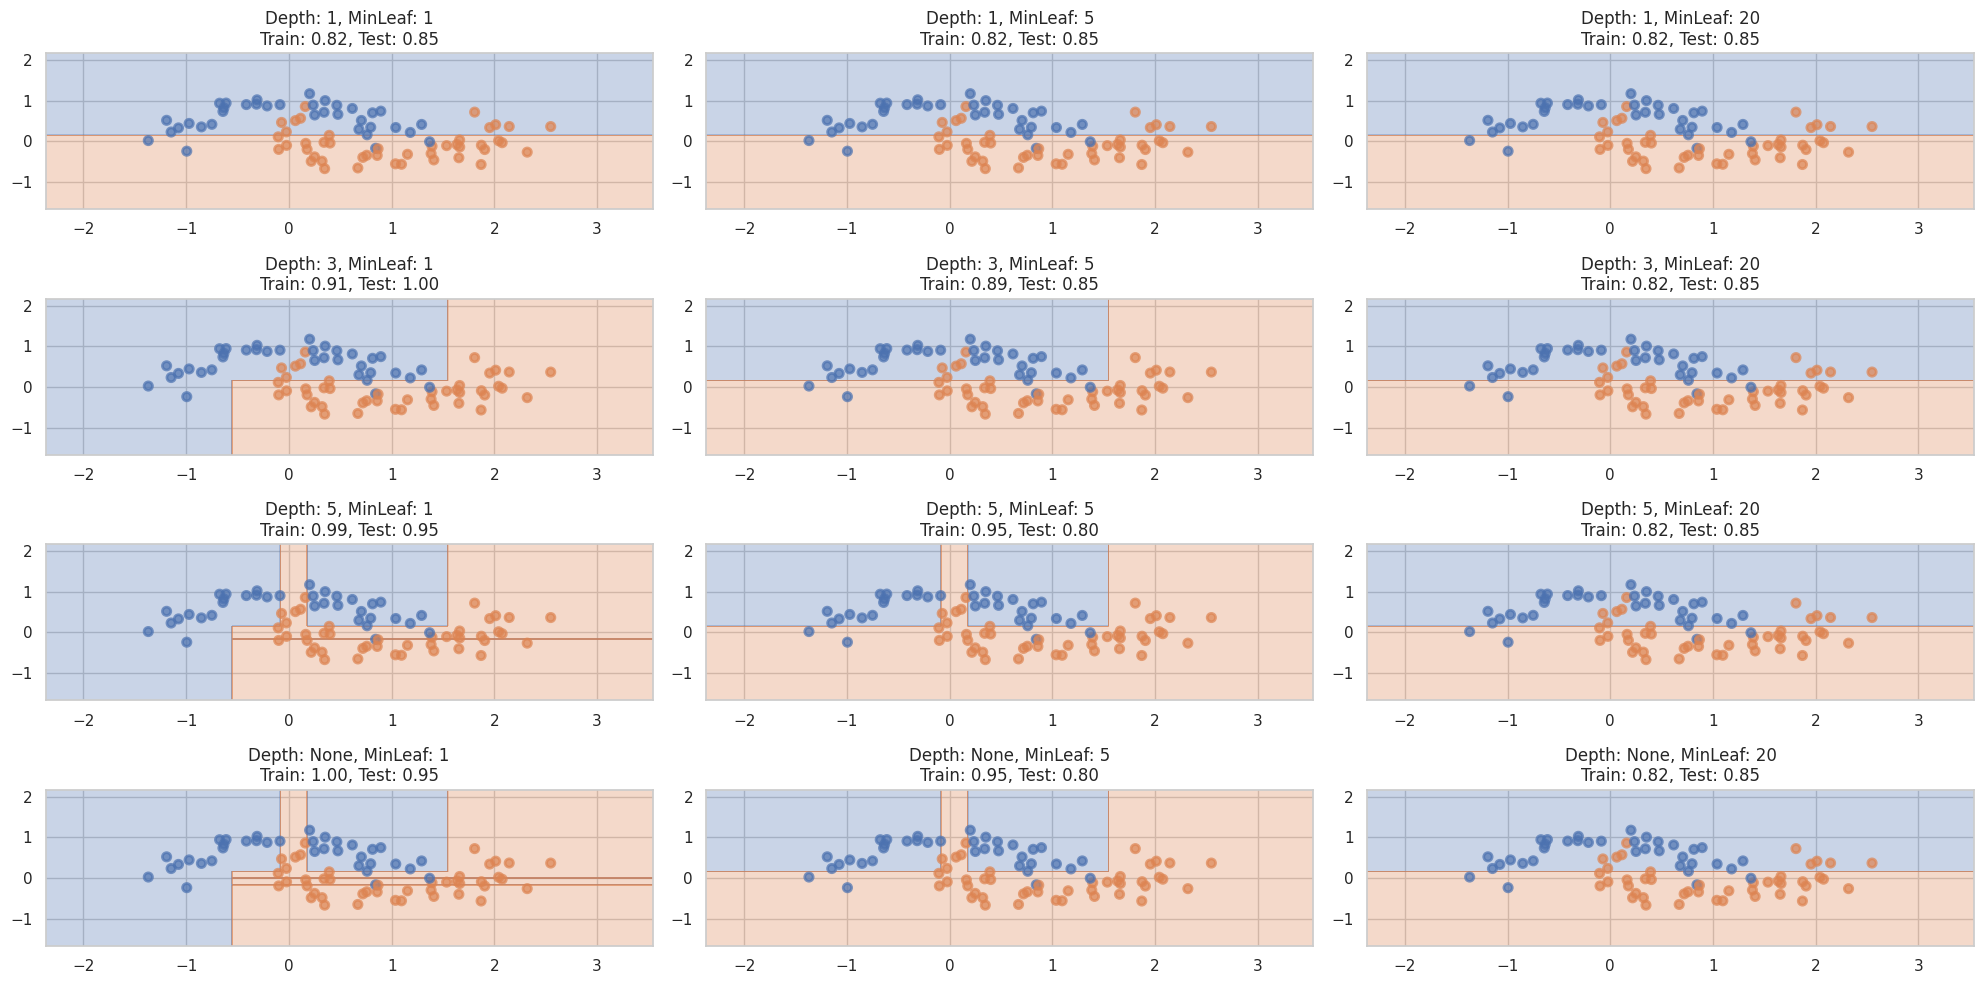

In [ ]:
#choose dataset
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depths = [1, 3, 5, None]
min_samples_leafs = [1, 5, 20]

plt.figure(figsize=(20, 10))
plot_index = 1

for depth in max_depths:
    for leaf in min_samples_leafs:
        clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        clf.fit(X_train, y_train)

        plt.subplot(4, 3, plot_index)
        plot_surface(clf, X_train, y_train)

        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))

        plt.title(f"Depth: {depth}, MinLeaf: {leaf}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}")
        plot_index += 1

plt.tight_layout()
plt.show()

__Ответ:__

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

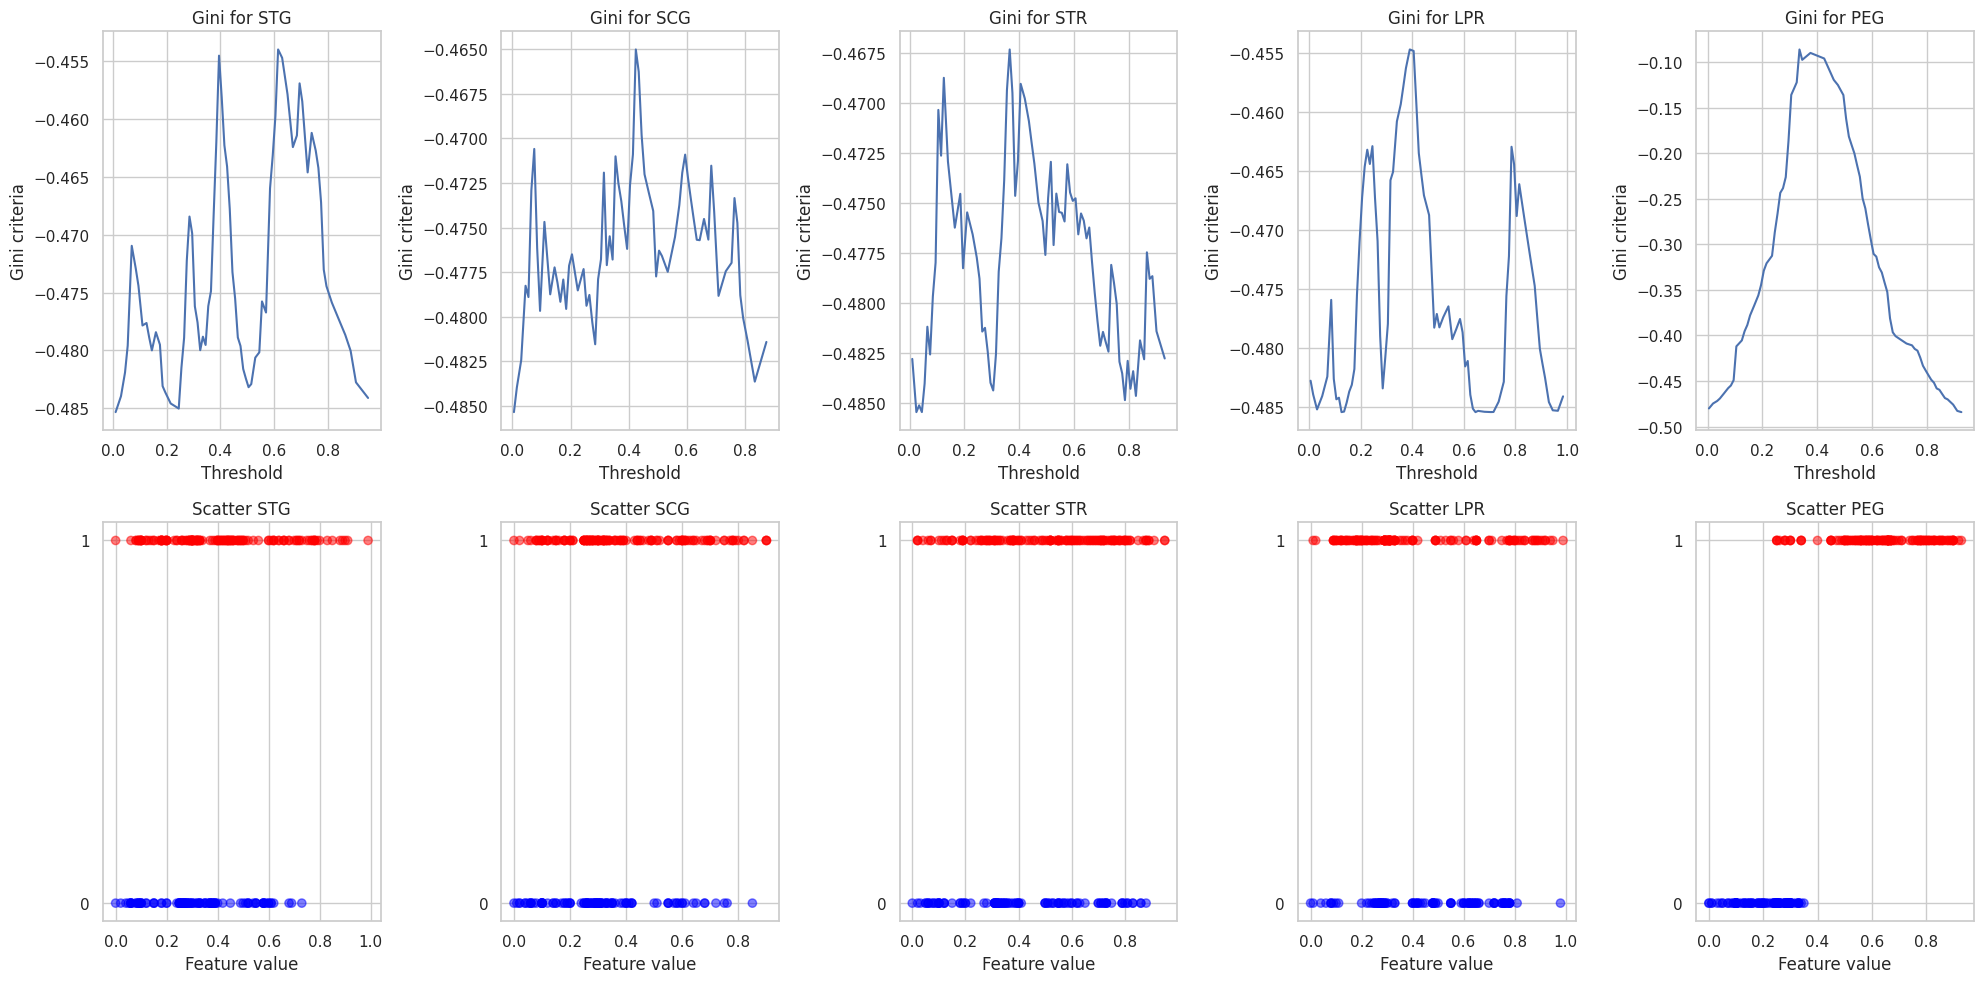

In [ ]:
df_students = pd.read_csv('students.csv')
y = df_students['UNS'].values
X = df_students.drop('UNS', axis=1)

plt.figure(figsize=(20, 10))

for i, col in enumerate(X.columns):
    feature_vector = X[col].values
    thresholds, ginis, _, _ = find_best_split(feature_vector, y)

    plt.subplot(2, 5, i + 1)
    plt.plot(thresholds, ginis)
    plt.title(f"Gini for {col}")
    plt.xlabel("Threshold")
    plt.ylabel("Gini criteria")

for i, col in enumerate(X.columns):
    plt.subplot(2, 5, i + 6)
    plt.scatter(X[col], y, alpha=0.5, c=y, cmap='bwr')
    plt.title(f"Scatter {col}")
    plt.xlabel("Feature value")
    plt.yticks([0, 1])

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Исходя из кривых Джини, наилучшим признаком для первого разбиения является PEG. Кривая для PEG имеет ярко выраженный пик, что говорит о наличии порога, который хорошо разделяет выборку резкое улучшение критерия информативности. Это согласуется со Scatter-графиком, там видно, что при низких значениях PEG объекты преимущественно класса 0, а при высоких - класса 1
Для плохих признаков кривая Джини выглядит плоской или хаотичной без явного глобального максимума, значительно превышающего другие точки например, STG или SCG, где классы перемешаны по всему диапазону значений

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [19]:
from sklearn.preprocessing import LabelEncoder

df_mush = pd.read_csv('agaricus-lepiota.data', header=None)

label_encoders = {}
for col in df_mush.columns:
    le = LabelEncoder()
    df_mush[col] = le.fit_transform(df_mush[col])
    label_encoders[col] = le

y_mush = df_mush[0].values
X_mush = df_mush.drop(0, axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X_mush, y_mush, test_size=0.5, random_state=42)

types = ['categorical'] * X_train.shape[1]
tree = DecisionTree(feature_types=types)
tree.fit(X_train, y_train)

preds = tree.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy on mushrooms: {acc}")

Accuracy on mushrooms: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

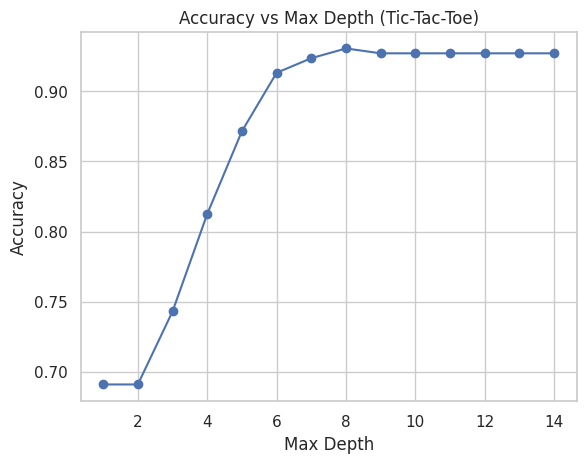

In [20]:
df_ttt = pd.read_csv('tic-tac-toe-endgame.csv')
le = LabelEncoder()
for col in df_ttt.columns:
    df_ttt[col] = le.fit_transform(df_ttt[col])

X = df_ttt.drop(columns=['V10']).values
y = df_ttt['V10'].values
types = ['categorical'] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

depths = range(1, 15)
accs = []

for d in depths:
    dt = DecisionTree(feature_types=types, max_depth=d)
    dt.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, dt.predict(X_test)))

plt.plot(depths, accs, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth (Tic-Tac-Toe)')
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np

from hw2code import DecisionTree

def custom_cv(model_class, X, y, cv=10, **model_params):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_class(**model_params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        scores.append(accuracy_score(y_test, preds))
    return np.mean(scores)


try:
    mush = pd.read_csv('agaricus-lepiota.data', header=None)
    for col in mush.columns:
        mush[col] = LabelEncoder().fit_transform(mush[col])
    X_mush = mush.drop(0, axis=1).values
    y_mush = mush[0].values
except:
    print("Ошибка загрузки Mushrooms. Загрузите файл agaricus-lepiota.data")
    X_mush, y_mush = None, None

try:
    ttt = pd.read_csv('tic-tac-toe-endgame.csv')
    for col in ttt.columns:
        ttt[col] = LabelEncoder().fit_transform(ttt[col])
    X_ttt = ttt.drop('V10', axis=1).values
    y_ttt = ttt['V10'].values
except:
    print("Ошибка загрузки Tic-Tac-Toe. Загрузите файл tic-tac-toe-endgame.csv")
    X_ttt, y_ttt = None, None

try:
    cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
    cars[6] = cars[6].apply(lambda x: 0 if x in ['unacc', 'acc'] else 1)
    for col in cars.columns[:-1]:
        cars[col] = LabelEncoder().fit_transform(cars[col])
    X_cars = cars.drop(6, axis=1).values
    y_cars = cars[6].values
except:
    print("Error loading cars dataset")
    X_cars, y_cars = None, None

try:
    nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
    target_map = {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
    nursery[8] = nursery[8].map(target_map)
    nursery = nursery.dropna(subset=[8])
    for col in nursery.columns[:-1]:
        nursery[col] = LabelEncoder().fit_transform(nursery[col])
    X_nurs = nursery.drop(8, axis=1).values
    y_nurs = nursery[8].astype(int).values

    if len(y_nurs) > 2000:
        idx = np.random.choice(len(y_nurs), 2000, replace=False)
        X_nurs = X_nurs[idx]
        y_nurs = y_nurs[idx]
except:
    print("Error loading nursery dataset")
    X_nurs, y_nurs = None, None

datasets_bench = [
    ("Mushrooms", X_mush, y_mush),
    ("Tic-Tac-Toe", X_ttt, y_ttt),
    ("Cars", X_cars, y_cars),
    ("Nursery", X_nurs, y_nurs)
]

results = []

for name, X, y in datasets_bench:
    if X is None: continue
    print(f"Processing {name}...")

    types_real = ['real'] * X.shape[1]
    score_real = custom_cv(DecisionTree, X, y, feature_types=types_real)

    types_cat = ['categorical'] * X.shape[1]
    score_cat = custom_cv(DecisionTree, X, y, feature_types=types_cat)

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X)
    types_ohe = ['real'] * X_ohe.shape[1]
    score_ohe = custom_cv(DecisionTree, X_ohe, y, feature_types=types_ohe)

    score_sklearn = cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy').mean()

    results.append({
        "Dataset": name,
        "Custom (Real)": score_real,
        "Custom (Cat)": score_cat,
        "Custom (OHE)": score_ohe,
        "Sklearn": score_sklearn
    })

df_res = pd.DataFrame(results)
print(df_res)

Processing Mushrooms...
Processing Tic-Tac-Toe...
Processing Cars...
Processing Nursery...
       Dataset  Custom (Real)  Custom (Cat)  Custom (OHE)   Sklearn
0    Mushrooms       1.000000      1.000000      1.000000  0.956689
1  Tic-Tac-Toe       0.878914      0.944715      0.944715  0.755022
2         Cars       0.990163      0.987273      0.987851  0.943285
3      Nursery       1.000000      1.000000      1.000000  1.000000


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
***Ранжирование алгоритмов: Алгоритмы ранжируются по-разному. На датасетах с явно категориальной природой и малым числом уникальных значений (Tic-Tac-Toe, Mushrooms) подход с явным указанием feature_types='categorical' реализующий разбиение множества категорий или OHE работают лучше или сравнимо с Sklearn. Sklearn работает только с вещественными числами , что накладывает ложный порядок на категории
2. В нашей реализации categorical разбиения, мы сортируем категории по вероятности попадания в целевой класс, что является оптимальным способом бинаризации категориального признака для бинарной классификации.
3. В DecisionTreeClassifier из sklearn есть случайность при выборе признака, если сплиты равнозначны . В нашей реализации детерминированный выбор (argmax первого попавшегося). На маленьких датасетах это может влиять на результат.***

спасибо некоторому xsestech что шарит во всем этом безобразии

Вставьте что угодно, описывающее ваши впечатления от этого задания:

боже храни инженеров